In [185]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import cm
import pandas as pd

In [186]:
positions = pd.read_csv('./Data/breweries_pos.csv')
col_names=['id', 'brewery_id', 'country', 'name', 'nbr_beers', 'long', 'lat']

positions.columns = col_names
positions = positions.drop(['id'],axis=1)

In [187]:
positions.head()

,brewery_id,country,name,nbr_beers,long,lat
0,3198,Gabon,Sobraga,3,0.303409,9.501448
1,13538,Northern Ireland,Ards Brewing Co.,13,54.553377,-5.567928
2,22304,Northern Ireland,Barrahooley Craft Brewery,4,51.590635,-0.057007
3,22818,Northern Ireland,Boundary,66,54.598563,-5.895088
4,24297,Northern Ireland,Brewbot Belfast,3,54.575613,-5.917369


In [188]:
Lat = positions['long']
Lon = positions['lat']

In [189]:
min_lon = -15 #-15 Europe, -5 Eq test
max_lon = 35 #35 Europe, 45 Eq test
min_lat = 30 #30 Europe, -10 Eq test
max_lat = 60 #60 Europe, 10 Eq test
res = 0.5 #resolution of X degrees

nx,ny = int((max_lon-min_lon)/res),int((max_lat-min_lat)/res)
lon_bins = np.linspace(min_lon,max_lon,nx+1)
lat_bins = np.linspace(min_lat,max_lat,ny+1)

In [190]:
density, _, _ = np.histogram2d(Lon,Lat,[lon_bins,lat_bins])

In [191]:
map = Basemap(projection='cyl',llcrnrlon=min_lon,llcrnrlat= min_lat, urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='f')


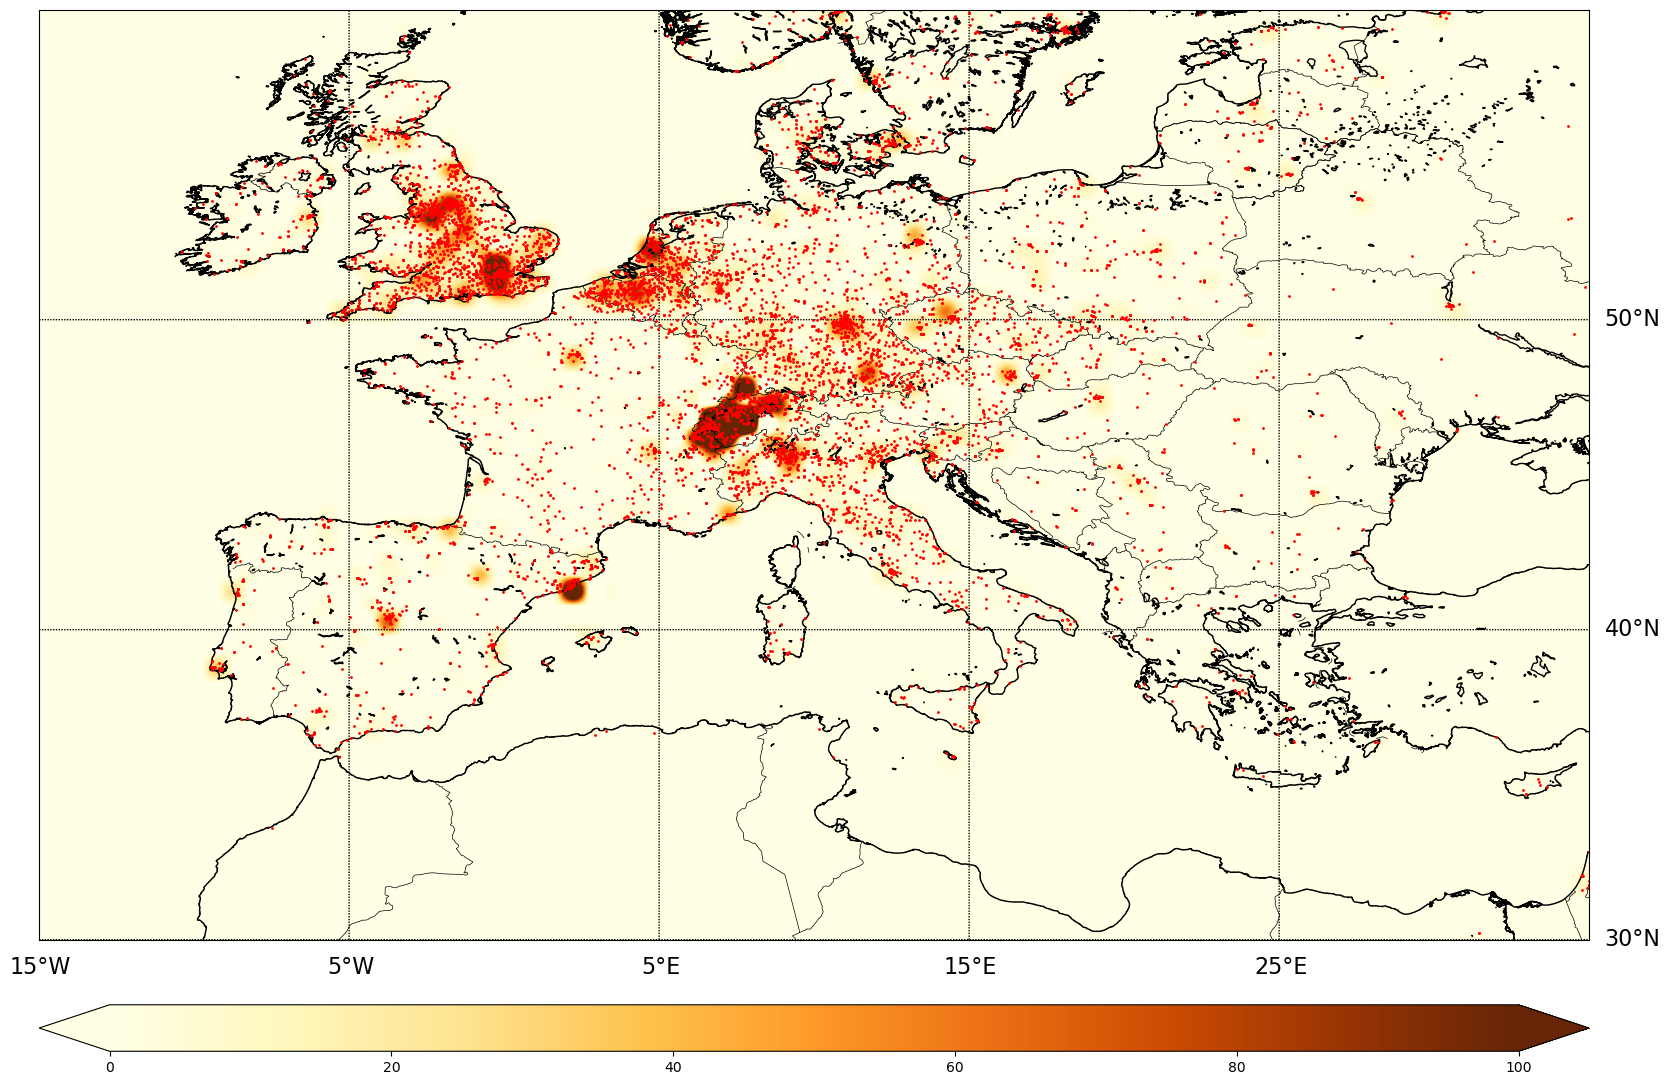

In [192]:
fig=plt.figure(figsize=(20,15))
map.drawcoastlines(linewidth=1)
map.drawstates()
map.drawcountries()
parallels = np.arange(min_lat,max_lat,10)
map.drawparallels(parallels,labels=[False,True,True,False],fontsize=16)
meridians = np.arange(min_lon,max_lon,10)
map.drawmeridians(meridians,labels=[True,False,False,True],fontsize=16)

a = map.imshow(density.T, interpolation='spline36', alpha=1, cmap='YlOrBr',vmin=0,vmax=100)
cbar = map.colorbar(a,'bottom', pad='7%',extend='both')

for lons, lats in zip(Lon, Lat):
    x, y = map.projtran(lons,lats)
    map.plot(x,y,'ro',markersize=1)